<a href="https://colab.research.google.com/github/Panda0riginal/ST_DeepLearning/blob/master/Code/Experiment_TemperatureData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatio-temporal prediction of temperature fields with Deep Learining

In this notebook we will introduce a methodology to perform interpolation of spatio-temporal datasets with deep learning models, capturing the spatial, temporal and spatio-temporal dependencies in data. We will here apply the method on real case study.

In [26]:
# Loading all the required libraries.
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
import tensorflow as tf
from tensorflow import keras

## Data preprocessing

We will use as case study hourly temperature measurements from 1st july 2016 00h00 to 30 june 2018 23h00 on 369 stations in Switzerland (and neighbouring countries). The dataset was randomly splitted into training and testing.

In [27]:
# Training/testing data
y_train = (pd.read_csv('Y_train.txt'))
y_test = (pd.read_csv('Y_test.txt'))

In [51]:
#X_train = pd.read_csv('X_train.txt', index_col=0).iloc[:,1:4]
X_train = pd.read_csv('X_train.txt')
X_test = pd.read_csv('X_test.txt')

In [29]:
y_train #arreglo de traspuesta (en el informe venia traspuesto)

,X1980.01.01,X1980.01.02,X1980.01.03,X1980.01.04,X1980.01.05,X1980.01.06,X1980.01.07,X1980.01.08,X1980.01.09,X1980.01.10,...,X2022.12.19,X2022.12.20,X2022.12.21,X2022.12.22,X2022.12.23,X2022.12.24,X2022.12.25,X2022.12.26,X2022.12.27,X2022.12.28
415,0.000000,0.015765,0.057459,0.450128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018157,0.032898,0.000000
463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000899,0.008089,0.000000,0.000000,0.000000,0.000000,0.086828,0.000000
179,0.950454,0.849643,0.691372,0.420672,0.345790,0.417769,0.533723,0.194157,0.027174,0.574588,...,0.472970,0.270911,0.478003,0.062740,0.122062,0.378951,4.084151,8.128932,0.393513,1.170291
526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.020134,0.026785,1.136854,0.000000,0.000000,0.000000,0.010965,0.000000,0.000000
195,0.141053,0.238755,0.024269,0.000000,0.000000,0.006223,0.022610,0.465064,0.777664,2.170988,...,1.629418,0.086828,0.000539,0.000000,0.000000,1.757952,1.755795,2.829369,0.247001,0.057706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0.000000,0.000000,0.000000,0.271944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.054649,6.055127,0.000000,0.000000,0.000000,0.006652,0.008089,0.000000
827,3.537968,3.408738,1.704472,4.876321,7.517146,4.005105,3.332403,3.471798,2.033045,10.199247,...,0.000000,0.175813,3.889462,7.872222,7.881392,1.532703,0.000000,4.164148,2.440353,19.585011
778,21.995934,10.173526,5.028371,2.842446,29.677160,16.368288,34.011463,19.534330,23.684021,13.473570,...,0.007550,0.000000,4.338162,10.600203,12.153041,3.345844,0.154421,23.977282,19.484156,39.880829
68,0.859392,0.008712,0.000000,0.007052,0.004149,0.045635,0.000000,0.177769,0.000000,0.000000,...,0.098333,0.355760,1.629598,0.461824,0.145972,0.000000,0.000000,0.409512,0.000539,0.000000


In [59]:
# The prediction mesh
Path_SwissMesh = r'malla_predecir.csv'
SwissMesh = pd.read_csv(Path_SwissMesh, header=0)
#SwissMesh = SwissMesh[SwissMesh['Switzerland'] != 0] # We only keep points in Switzerland for the prediction maps
columnsTitles = ['X', 'Y']
SwissMesh = SwissMesh.reindex(columns=columnsTitles)
SwissMesh["Z"]=0 #Simulada altura por mientras

In [60]:
SwissMesh

,X,Y,Z
0,-76.00,-36.0,0
1,-75.75,-36.0,0
2,-75.50,-36.0,0
3,-75.25,-36.0,0
4,-75.00,-36.0,0
...,...,...,...
1676,-67.00,-46.0,0
1677,-66.75,-46.0,0
1678,-66.50,-46.0,0
1679,-66.25,-46.0,0


## SVD decomposition of training data

We want to decompose the training target values using a SVD (EOF).  In this way we will obtain three objcets: a set of principal component time series, a set of eigenvalues and a set of spatial coeffiecents. Moreover, we need to store the temporal mean of the raw data. As we will subtract this quantity before performing svd, we will need it later on to reconstruct the original signal.
The decomposition is done accoring to Wikle, 2019.

In [62]:
Z = tf.constant(y_train.values, dtype=tf.float32)
print('Matrix Z: \n{}\n'.format(Z))

time_mean = tf.reduce_mean(Z, 0)
nS = tf.constant(Z.shape[0], dtype =tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])

Ztime_detrend = Z - time_mean
Ztilde = 1/tf.sqrt(nS-1)*Ztime_detrend
#print('Matrix Ztiled: \n{}\n'.format(Ztilde))

# Using tf.linalg.svd to calculate the singular value decomposition
s, u, v = tf.linalg.svd(Ztilde)

u =  u * tf.sqrt(nS-1)
print('Diagonal S: \n{} \n\nMatrix U: \n{} \n\nMatrix V^T: \n{}'.format(s, u, v))

Matrix Z: 
[[0.0000000e+00 1.5764963e-02 5.7458878e-02 ... 1.8156599e-02
  3.2897573e-02 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  8.6828135e-02 0.0000000e+00]
 [9.5045429e-01 8.4964281e-01 6.9137198e-01 ... 8.1289320e+00
  3.9351267e-01 1.1702906e+00]
 ...
 [2.1995934e+01 1.0173526e+01 5.0283709e+00 ... 2.3977282e+01
  1.9484156e+01 3.9880829e+01]
 [8.5939234e-01 8.7120570e-03 0.0000000e+00 ... 4.0951186e-01
  5.3923577e-04 0.0000000e+00]
 [9.0855643e-02 0.0000000e+00 0.0000000e+00 ... 3.0556694e-03
  0.0000000e+00 0.0000000e+00]]

Diagonal S: 
[5.50981384e+02 4.44922699e+02 2.80566132e+02 2.31648392e+02
 1.77036087e+02 1.43793198e+02 1.22972702e+02 1.16344276e+02
 1.01617844e+02 9.63526230e+01 8.19309158e+01 7.73005295e+01
 7.54804688e+01 6.95422211e+01 6.50197144e+01 6.10733528e+01
 5.62816315e+01 4.97818451e+01 4.92391701e+01 4.57795258e+01
 4.44346733e+01 4.27018929e+01 4.15287628e+01 4.08180351e+01
 3.86253090e+01 3.80956497e+01 3.63992920e+01

We plot the first three elements of the temporal basis and the corresponding spatial coefficients

Text(0.5, 1.0, 'EOF 3 (spatial coefficients)')

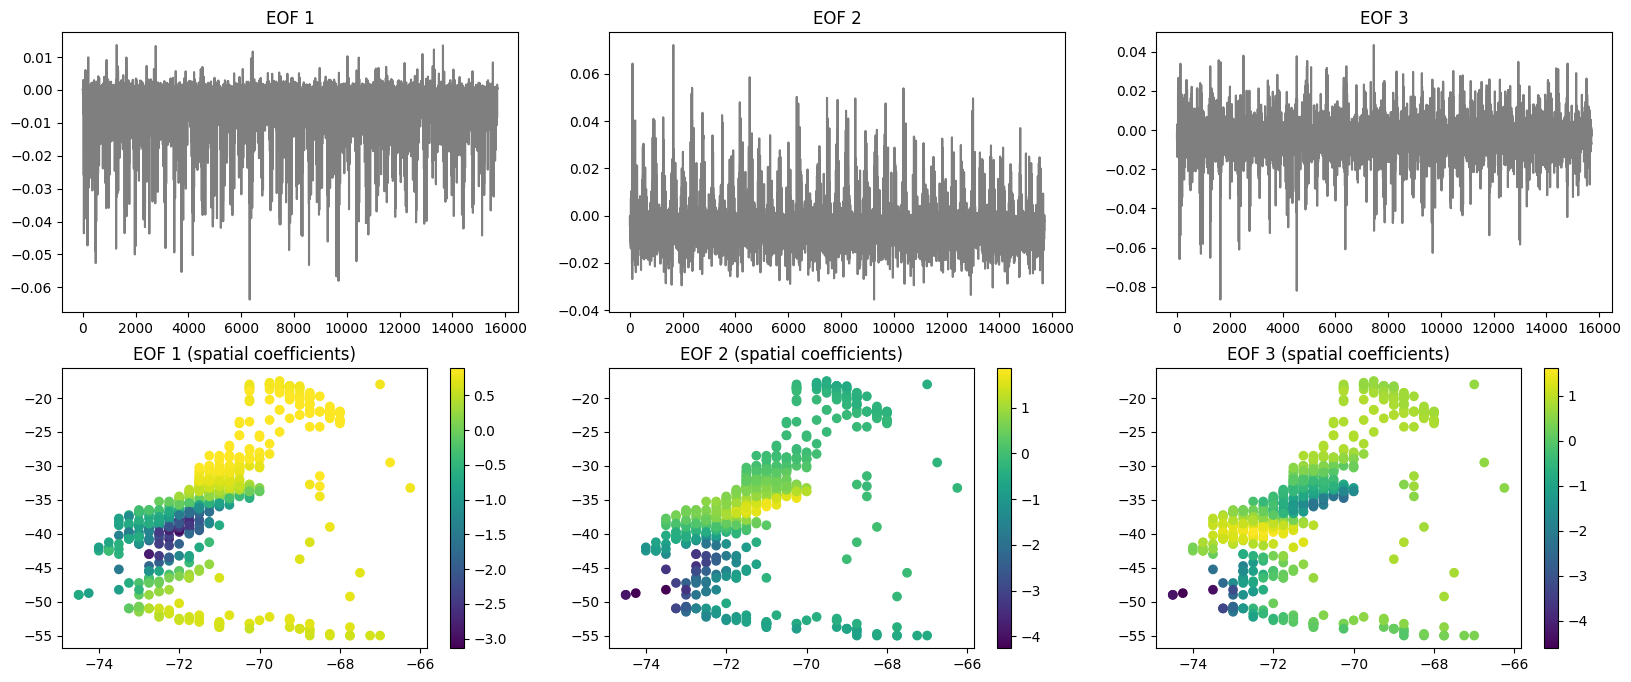

In [63]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.plot(np.arange(len(v[:,0])), v[:,0], color='black', alpha=0.5)
plt.title('EOF 1')
plt.subplot(2,3,2)
plt.plot(np.arange(len(v[:,1])), v[:,1], color='black', alpha=0.5)
plt.title('EOF 2')
plt.subplot(2,3,3)
plt.plot(np.arange(len(v[:,2])), v[:,2], color='black', alpha=0.5)
plt.title('EOF 3')


plt.subplot(2,3,4)
plt.scatter(X_train['X'], X_train['Y'],c=u[:,0])
plt.colorbar()
plt.title('EOF 1 (spatial coefficients)')
plt.subplot(2,3,5)
plt.scatter(X_train['X'], X_train['Y'],c=u[:,1])
plt.colorbar()
plt.title('EOF 2 (spatial coefficients)')
plt.subplot(2,3,6)
plt.scatter(X_train['X'], X_train['Y'],c=u[:,2])
plt.colorbar()
plt.title('EOF 3 (spatial coefficients)')

We can  plot the percentage of explained variance.

Text(0.5, 0, 'Number of components')

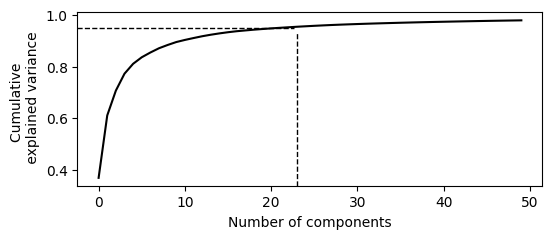

In [64]:
plt.figure(figsize=(6,2.25))
plt.plot(np.arange(50), (np.cumsum(tf.math.square(s)/tf.reduce_sum(tf.math.square(s))))[:50], c='black')
plt.axhline(0.9503357, xmax=0.465, color='black', linestyle='--', linewidth =1)
plt.axvline(23,ymax=0.885, color='black', linestyle='--', linewidth =1)
plt.ylabel('Cumulative \n explained variance')
plt.xlabel('Number of components')
#plt.savefig('Temperature_screeplot.pdf', dpi=300)

To verify if we correctly decompose data, we can reconstruct the original signal and check if we obtain the same values of wind speed as in the origianl dataset.

In [65]:
# To recompose
tf_Z_approx = tf.matmul((u/tf.sqrt(nS-1)), tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))

print('Matrix Zt, reconstructed: \n{}\n'.format(tf_Z_approx))

reconstructed = tf_Z_approx * tf.sqrt(nS-1) + time_mean

check = reconstructed - Z
print('True - reconstructed data: \n{}\n'.format(check))

Matrix Zt, reconstructed: 
[[-3.9042648e-02 -2.0385865e-02 -1.1275652e-02 ... -7.7676103e-02
  -3.9470945e-02 -8.3412416e-02]
 [-3.9025035e-02 -2.1012751e-02 -1.3565127e-02 ... -7.8398839e-02
  -3.7320461e-02 -8.3410323e-02]
 [-1.1352680e-03  1.2861136e-02  1.3994316e-02 ...  2.4572285e-01
  -2.5091773e-02 -3.6749866e-02]
 ...
 [ 8.3803958e-01  3.8463509e-01  1.8693174e-01 ...  8.7763911e-01
   7.3610288e-01  1.5067428e+00]
 [-4.7587426e-03 -2.0667268e-02 -1.3566171e-02 ... -6.2070776e-02
  -4.0760882e-02 -8.3411813e-02]
 [-3.5397559e-02 -2.1013265e-02 -1.3560005e-02 ... -7.8277253e-02
  -4.0782213e-02 -8.3412148e-02]]

True - reconstructed data: 
[[-2.7424097e-04 -4.2747706e-05 -1.5050173e-05 ... -2.5462359e-05
  -1.1425465e-05 -1.4066696e-05]
 [ 1.6748905e-04  0.0000000e+00  2.4080276e-05 ...  5.0067902e-06
  -8.1881881e-06  3.8623810e-05]
 [-1.6272068e-05 -9.0062618e-05 -1.6063452e-04 ...  2.8610229e-06
   1.2516975e-06 -1.3709068e-05]
 ...
 [ 9.0217590e-04  6.9618225e-05  8.9168549

## Modelling the coefficient maps and reconstruction of the full spatio-temporal field

We will model the coefficients using a deep feedforward fully connected neural network.
Latitude, longitude and elevation are used as inputs for a neural network having a first auxiliary output layer where the spatial coefficients are modelled.
A recomposition layer will then use the $\tilde K$ modelled coefficients and the temporal bases $\phi_k$ resulting from the EOFs decomposition in order to reconstruct the final output -- i.e. the spatio-temporal field --.

The described network has multiple inputs, namely the spatial covariates -- which flow through the full stack of layers -- and the temporal bases directly connected to the output layer. It also has multiple outputs, namely the spatial coefficients for each basis, all modelled jointly, and the output signal. While the network is trained by minimizing the loss function on the final output, having as auxiliary output the spatial coefficients maps ensures a better explainability of the model, which is of primary importance in earth and climate sciences.

In [66]:
X_train, X_valid = X_train.values[:220,:], X_train.values[220:,:]


In [67]:
n_eofs = 294
#X_train, X_valid = X_train.values[:220,:], X_train.values[220:,:]
u_train, u_valid = tf.random.shuffle(u[:220,:n_eofs]), tf.random.shuffle(u[220:,:n_eofs])
u_train, u_valid = u[:220,:n_eofs], u[220:,:n_eofs]
s = s[:n_eofs]
v = v[:,:n_eofs]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)
X_mesh = scaler.transform(SwissMesh)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


We now have to implement the neural netweork. We first define a custom recostruction layer. Then, we define a model using tensorflow functional functional API.

In [68]:
def recompose(x):
    U = tf.cast(x, dtype=tf.float32)
    U = U/tf.sqrt(nS-1)
    test_mean = tf.reshape(time_mean[0,:], [1, time_mean[0,:].shape[0]])
    y_hat = (tf.matmul(U, tf.matmul(tf.linalg.diag(s), v, adjoint_b=True))) *  tf.sqrt(nS-1) + test_mean
    return y_hat

input_A = keras.layers.Input(shape=[3,]) # The input are the geographical variables X, Y, Z
batch1 = keras.layers.BatchNormalization()(input_A)
hidden_1 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch1)
batch2 = keras.layers.BatchNormalization()(hidden_1)
hidden_2 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch2)
batch3 = keras.layers.BatchNormalization()(hidden_2)
hidden_3 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch3)
batch4 = keras.layers.BatchNormalization()(hidden_3)
hidden_4 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch4)
batch5 = keras.layers.BatchNormalization()(hidden_4)
hidden_5 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch5)
batch6 = keras.layers.BatchNormalization()(hidden_5)
aux_output = keras.layers.Dense(n_eofs)(batch6)# Auxiliary output: spatial coefficients u
output = keras.layers.Lambda(recompose)(aux_output) # Main output: reconstructed y




K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
batch_size = 32
n_epochs = 200
patience = 20
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.005)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True)

Now we are ready to execute the model. The first model we train models all the 293 components.

In [69]:
model = keras.Model(inputs=[input_A], outputs=[output, aux_output])
model.compile(loss=['mae', 'mae'], loss_weights=[1.0,0.0], optimizer="nadam")

history = model.fit([X_train], [y_train.values[:220,:], u_train], epochs=n_epochs,
                    validation_data=([X_valid], [y_train.values[220:,:], u_valid]),
                   callbacks=[onecycle, early_stopping_cb], verbose = 0)

In [70]:
y_hat_test, y_pred_test = model.predict([X_test])
y_hat_mesh, y_pred_mesh = model.predict([X_mesh])

53/53 [==============================] - 6s 107ms/step


We can explore how the test mae changed over time.

Text(0.5, 1.0, 'Test MAE')

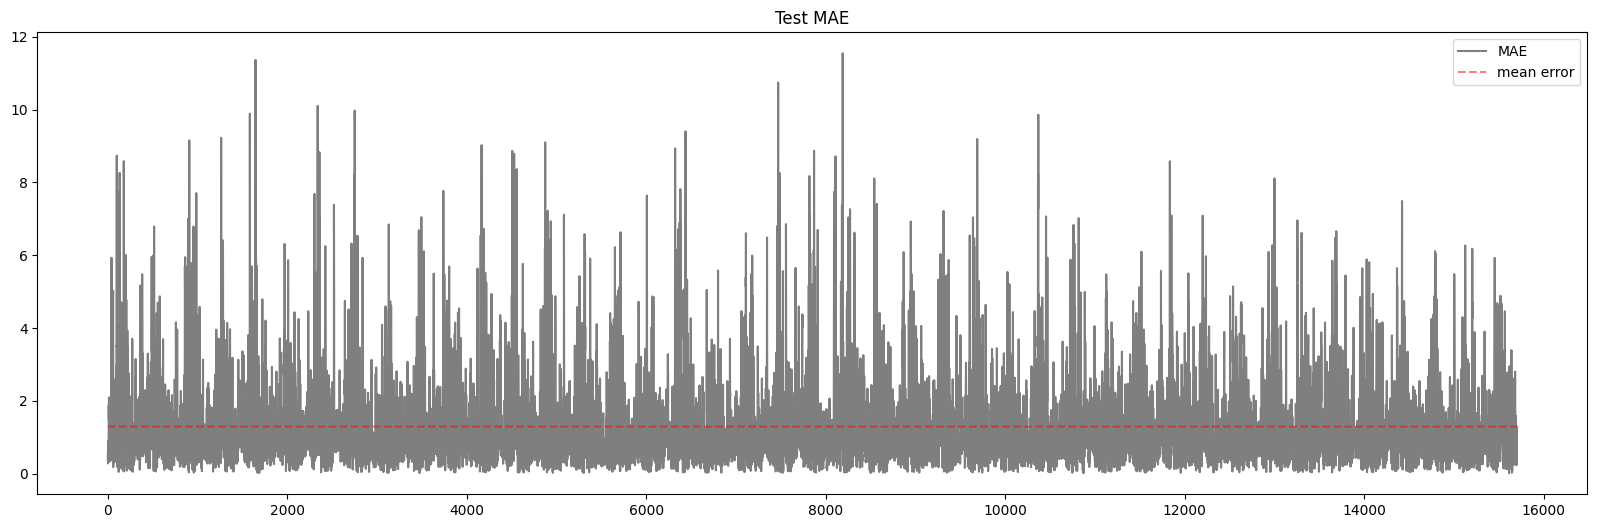

In [71]:
mae = np.zeros(y_test.shape[1])
for i in range(y_test.shape[1]):
    y_test_notna = (y_test.iloc[:,i]).reset_index().drop(['index'], axis = 1).dropna()
    idx = y_test_notna.index
    mae[i] = MAE(y_test_notna, np.array(y_hat_test)[idx,i])
plt.figure(figsize=(20,6))
plt.plot(np.arange(len(mae)), mae, c='black', alpha=0.5, label = 'MAE')
plt.plot(np.arange(len(mae)), np.tile(np.mean(mae), len(mae)), c='red', alpha=0.5, linestyle='--', label='mean error')
plt.legend()
plt.title('Test MAE')

Now let's see how the coefficient maps look like.

In [74]:
# Training/testing data
y_train_ = (pd.read_csv('Y_train.txt'))
y_test_ = (pd.read_csv('Y_test.txt'))

X_train_ = pd.read_csv('X_train.txt')
X_test_ = pd.read_csv('X_test.txt')

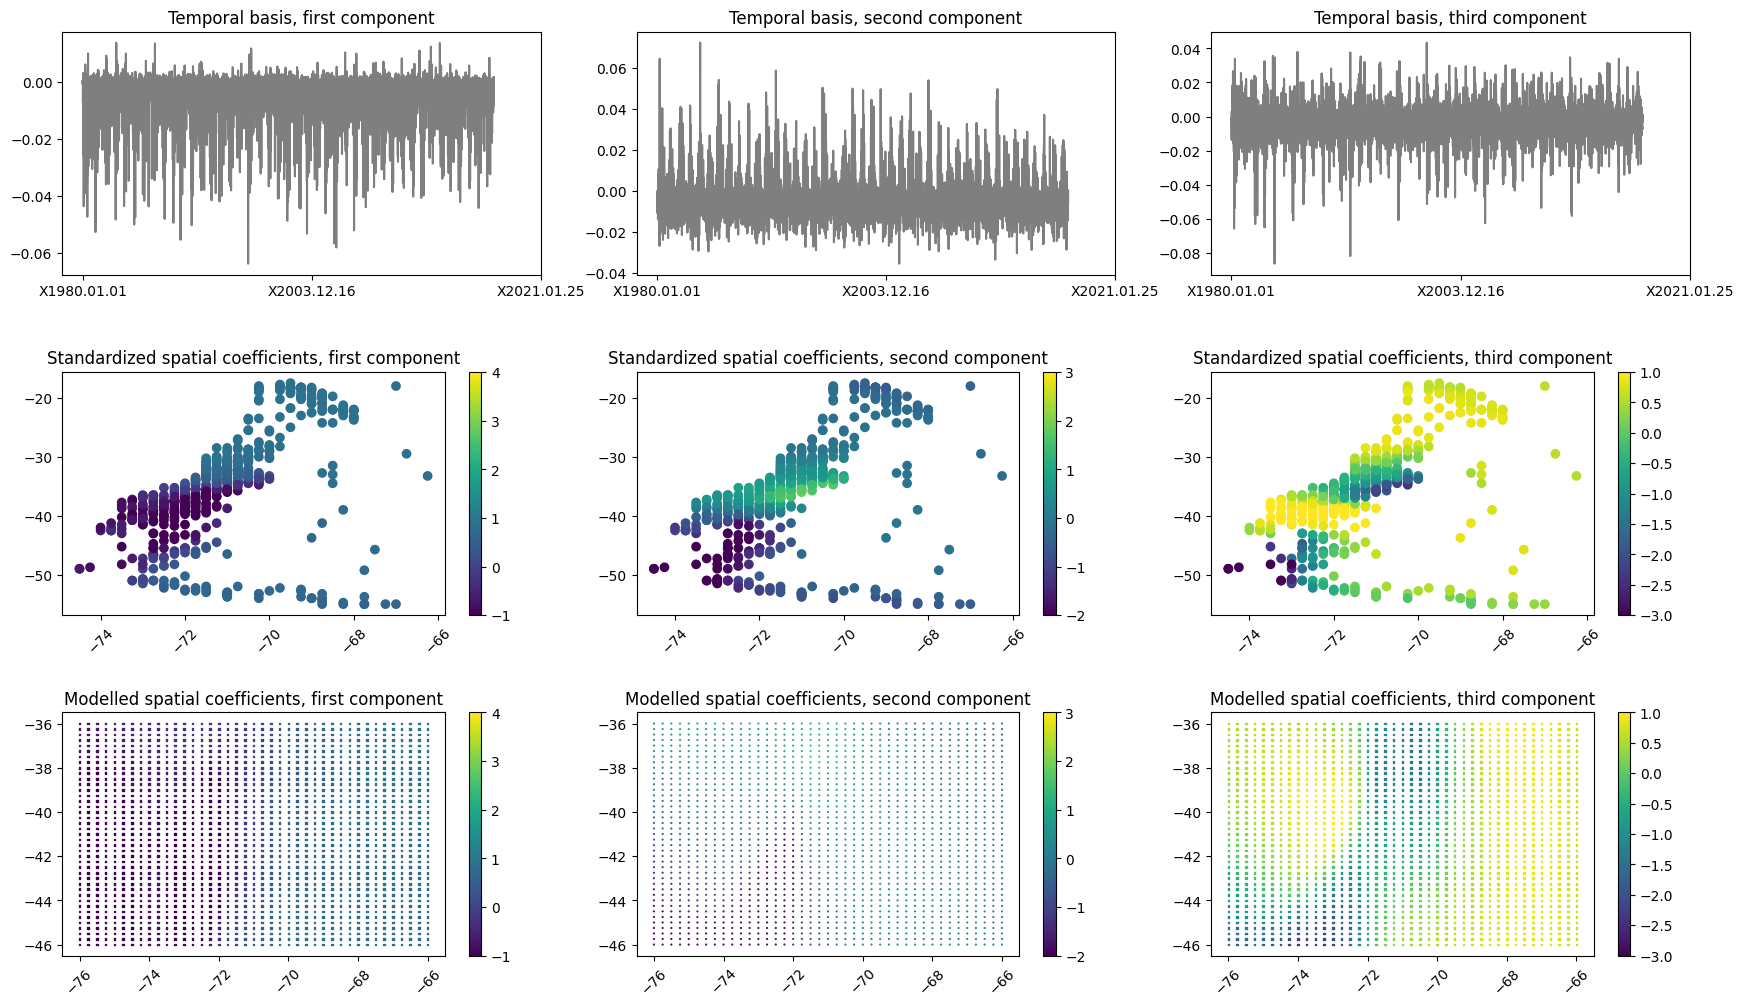

In [78]:
Z_ = tf.constant(y_train_.values, dtype=tf.float32)

time_mean_ = tf.reduce_mean(Z_, 0)
nS = tf.constant(Z_.shape[0], dtype =tf.float32)
time_mean_ = tf.reshape(tf.tile(time_mean_, [nS]), [nS, time_mean_.shape[0]])

Ztime_detrend_ = Z_ - time_mean_
Ztilde_ = 1/tf.sqrt(nS-1)*Ztime_detrend_
s_, u_, v_ = tf.linalg.svd(Ztilde_)
u_ =  u_ * tf.sqrt(nS-1)

plt.figure(figsize=(21,12))
plt.subplot(3,3,1)
plt.plot(np.arange(len(v_[:,0])), v_[:,0], color='black', alpha=0.5)
plt.xticks([0, 8750, 17500], [list(y_test.columns)[i] for i in [0, 8750, 15000]])
plt.title('Temporal basis, first component')
plt.subplot(3,3,2)
plt.plot(np.arange(len(v_[:,1])), v_[:,1], color='black', alpha=0.5)
plt.xticks([0, 8750, 17500], [list(y_test.columns)[i] for i in [0, 8750, 15000]])
plt.title('Temporal basis, second component')
plt.subplot(3,3,3)
plt.plot(np.arange(len(v_[:,2])), v_[:,2], color='black', alpha=0.5)
plt.xticks([0, 8750, 17500], [list(y_test.columns)[i] for i in [0, 8750, 15000]])
plt.title('Temporal basis, third component')


plt.subplot(3,3,4)
plt.scatter(X_train_['X'], X_train_['Y'],c=u_[:,0], vmin=-1, vmax=4)
plt.xticks(rotation=45)
plt.colorbar()
plt.title('Standardized spatial coefficients, first component')
plt.subplot(3,3,5)
plt.scatter(X_train_['X'], X_train_['Y'],c=u_[:,1], vmin=-2, vmax=3)
plt.xticks(rotation=45)
plt.colorbar()
plt.title('Standardized spatial coefficients, second component')
plt.subplot(3,3,6)
plt.scatter(X_train_['X'], X_train_['Y'],c=u_[:,2], vmin=-3, vmax=1)
plt.xticks(rotation=45)
plt.colorbar()
plt.title('Standardized spatial coefficients, third component')

plt.subplot(3,3,7)
plt.scatter(SwissMesh['X'], SwissMesh['Y'],c= y_pred_mesh[:,0], vmin=-1, vmax=4, marker =',', s =1.3)
plt.xticks(rotation=45)
plt.colorbar()
plt.title('Modelled spatial coefficients, first component')
plt.subplot(3,3,8)
plt.scatter(SwissMesh['X'], SwissMesh['Y'],c= y_pred_mesh[:,1], vmin=-2, vmax=3, marker ='.', s =1.3)

plt.xticks(rotation=45)
plt.colorbar()
plt.title('Modelled spatial coefficients, second component')
plt.subplot(3,3,9)
plt.scatter(SwissMesh['X'], SwissMesh['Y'],c= y_pred_mesh[:,2], vmin=-3, vmax=1, marker =',', s =1.3)
plt.xticks(rotation=45)
plt.colorbar()
plt.title('Modelled spatial coefficients, third component')
plt.subplots_adjust(hspace = 0.4, wspace = 0.2)

#plt.savefig('Temperature_eofs_allmesh.pdf', dpi=300)

We now perform a second experience where we adopt a compressed signal keeping 95 \% of data variance ($\tilde K = 24$).

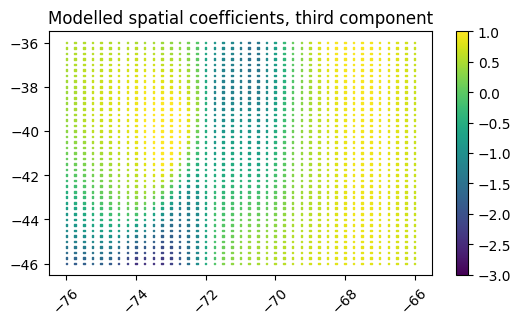

In [87]:
plt.figure(figsize=(21,12))
plt.subplot(3,3,9)
plt.scatter(SwissMesh['X'], SwissMesh['Y'],c= y_pred_mesh[:,2], vmin=-3, vmax=1, marker =',', s =1.3)
plt.xticks(rotation=45)
plt.colorbar()
plt.title('Modelled spatial coefficients, third component')
plt.subplots_adjust(hspace = 0.4, wspace = 0.2)

In [79]:
mae_spatial =  np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    y_test_notna = (y_test.iloc[i,:]).reset_index().drop(['time'], axis = 1).dropna()
    idx = y_test_notna.index
    mae_spatial[i] = MAE(y_test_notna.values, np.array(y_hat_test)[i,idx])

n_eofs= 23 # 0 indexed
y_train = (pd.read_csv('Temperature_f1Hour_20162018_FilledData_train.txt', index_col=0)).T
y_test = (pd.read_csv('Temperature_f1Hour_20162018_CleanedData_test.txt', index_col=0)).T
Z = tf.constant(y_train.values, dtype=tf.float32)
time_mean = tf.reduce_mean(Z, 0)
nS = tf.constant(Z.shape[0], dtype =tf.float32)
time_mean = tf.reshape(tf.tile(time_mean, [nS]), [nS, time_mean.shape[0]])
Ztime_detrend = Z - time_mean
Ztilde = 1/tf.sqrt(nS-1)*Ztime_detrend
s, u, v = tf.linalg.svd(Ztilde)
u_train, u_valid = u[:220,:n_eofs], u[220:,:n_eofs]
s = s[:n_eofs]
v = v[:,:n_eofs]
# Redefining callbacks
batch_size = 32
n_epochs = 200
patience = 20
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.005)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights = True)
# Redefining network structure
input_A = keras.layers.Input(shape=[3,]) # The input are the geographical variables X, Y, Z
batch1 = keras.layers.BatchNormalization()(input_A)
hidden_1 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch1)
batch2 = keras.layers.BatchNormalization()(hidden_1)
hidden_2 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch2)
batch3 = keras.layers.BatchNormalization()(hidden_2)
hidden_3 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch3)
batch4 = keras.layers.BatchNormalization()(hidden_3)
hidden_4 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch4)
batch5 = keras.layers.BatchNormalization()(hidden_4)
hidden_5 = keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal")(batch5)
batch6 = keras.layers.BatchNormalization()(hidden_5)
aux_output = keras.layers.Dense(n_eofs)(batch6)# Auxiliary output: spatial coefficients u
output = keras.layers.Lambda(recompose)(aux_output) # Main output: reconstructed y

model = keras.Model(inputs=[input_A], outputs=[output, aux_output])
#model.set_weights(initial_weights) # restoring initial weights
model.compile(loss=['mae', 'mae'], loss_weights=[1,0.0], optimizer="nadam")

history = model.fit([X_train], [y_train.values[:220,:], u_train], epochs=n_epochs,
                    validation_data=([X_valid], [y_train.values[220:,:], u_valid]),
                   callbacks=[onecycle, early_stopping_cb], verbose=0)

idx = np.argmin(np.asarray(history.history[list(history.history.keys())[-3]]))
y_hat_test_, y_pred_test_ = model.predict([X_test])
y_hat_mesh_, y_pred_mesh_ = model.predict([X_mesh])

KeyError: ignored

In [ ]:
seed = np.random.seed(seed=0)
idx = np.random.randint(0, 1008)
idx2 = np.random.randint(0, mae_spatial.shape[0])
coords = (scaler.inverse_transform(X_test))[idx2,:]


plt.figure(figsize=(13,11))
plt.subplots_adjust(wspace = 0.18, hspace =0.4)
plt.subplot(3,2,1)
plt.scatter(SwissMesh['X'], SwissMesh['Y'],c=y_hat_mesh[:,idx], marker =',', s =1.5,  vmin=0, vmax=28)
plt.colorbar(label='Temperature [$C^\circ$]')
plt.xticks(rotation = 45)

plt.scatter(coords[0], coords[1], c ='red', marker='+', s=150)
plt.title('Predicted map (all components)')
plt.subplot(3,2,2)
plt.scatter(SwissMesh['X'], SwissMesh['Y'],c=y_hat_mesh_[:,idx], marker =',', s =1.55,  vmin=0, vmax=28)
plt.colorbar(label='Temperature [$C^\circ$]')
plt.xticks(rotation = 45)
plt.scatter(coords[0], coords[1], c ='red', marker='+', s=150)
plt.title('Predicted map (24 components)')

plt.subplot(312)
plt.axvline(idx, color='black', linestyle='--', linewidth=1)
y_test.iloc[idx2,:1008].plot(label = 'True', color = 'black', linewidth = 1)
#plt.plot(np.arange(1008), y_test.values[idx2,:1008], label='True', color = 'black', linewidth = 1)
plt.plot(np.arange(1008), y_hat_test[idx2,:1008], label='Predicted (all components)', color = 'orange', linewidth = 1.2)
plt.plot(np.arange(1008), y_hat_test_[idx2,:1008], label='Predicted (24 components)', color = 'green', linewidth = 0.8, alpha = 1, linestyle ='--')
plt.title('True versus predicted time series')
plt.ylabel('Temperature [$C^\circ$]')
plt.xlabel('')
plt.legend(loc=1, fontsize=9)

plt.subplot(3,2,5)
plt.scatter(y_test.values[idx2,:], y_hat_test[idx2,:], label = 'true vs all components', color = 'orange', alpha = 0.3)
plt.plot([y_test.iloc[idx2,:].min(), y_test.iloc[idx2,:].max()],[y_test.iloc[idx2,:].min(), y_test.iloc[idx2,:].max()], linestyle='--', dashes=(5, 2), c ='black')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.title('Accuracy plot (all components)')

plt.subplot(3,2,6)
plt.title('Accuracy plot (24 components)')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.scatter(y_test.values[idx2,:], y_hat_test_[idx2,:], color = 'green', alpha = 0.3)
plt.plot([y_test.iloc[idx2,:].min(), y_test.iloc[idx2,:].max()],[y_test.iloc[idx2,:].min(), y_test.iloc[idx2,:].max()], linestyle='--', dashes=(5, 2), c ='black')
plt.savefig('Temperature_prediction_allmesh.png', dpi =300)

 We can also check if the prediction range is in line with the train data range.

In [ ]:
def control_stats(y_train, y_hat_mesh, time_mean, SwissMesh, s, v, nS, n_eofs):
    '''
    Function  to compute 'control stats' of the prediction maps.
    -------------------------------------------------------------
    Parameters:
    - y_train: array-like of shape = [n_samples]
      The training output samples before EOF decomposition.
    - y_hat_mesh: dictionary-like
      Dictionary resuling from the function ELM_executor.
    - time_mean: array-like of shape = [n_samples, timestamps]
      The temporal mean subtracted from data before performing the EOF decomposition
    - SwissMesh: array-like of shape = [n_samples, n_features]
      The prediction grid
    - s: array-like of shape = [n_EOF]
      The singular values resulting from the EOF decomposition
    - v: array-like of shape = [timesteps, n_samples]
      The principal components timeseries derived from the EOF decomposition
    - nS: array-like of shape = [n_trianing_samples]
      The previously computed number of training points
    - n_eofs: int or str, default = 'All'
      The number of EOF to be modelled. If all the EOFs have to be
      considered then set this parameter to 'All'; diversly, specify the
      number of EOFs.
    '''
    prediction_range =  y_test.shape[1]
    y_mean = np.zeros((1, prediction_range))
    y_var = np.zeros((1, prediction_range))
    y_min = np.zeros((1, prediction_range))
    y_max = np.zeros((1, prediction_range))
    mesh_mean = np.zeros((1, prediction_range))
    mesh_var = np.zeros((1, prediction_range))
    mesh_min = np.zeros((1, prediction_range))
    mesh_max = np.zeros((1, prediction_range))
    i = 0
    for t in range(0, prediction_range):
        y_mean[0, i] = np.mean(y_train.iloc[:, t].values)
        y_var[0, i] = np.var(y_train.iloc[:, t].values)
        y_min[0, i] = np.min(y_train.iloc[:, t].values)
        y_max[0, i] = np.max(y_train.iloc[:, t].values)
        mesh_mean[0, i] = np.mean(y_hat_mesh[:, i])
        mesh_var[0, i] = np.var(y_hat_mesh[:, i])
        mesh_min[0, i] = np.min(y_hat_mesh[:, i])
        mesh_max[0, i] = np.max(y_hat_mesh[:, i])
        i += 1
    stats = pd.DataFrame({'y_mean':y_mean.ravel()[:,],'y_var':y_var.ravel()[:,],'y_min':y_min.ravel()[:,],'y_max':y_max.ravel()[:,],
                          'mesh_mean':mesh_mean.ravel()[:,],'mesh_var':mesh_var.ravel()[:,],'mesh_min':mesh_min.ravel()[:,],'mesh_max':mesh_max.ravel()[:,]})
    return stats

stats = control_stats(y_train,y_hat_mesh, time_mean, SwissMesh, s, v, nS, n_eofs)
stats_ = control_stats(y_train,y_hat_mesh_, time_mean, SwissMesh, s, v, nS, n_eofs)

In [ ]:
plt.figure(figsize=(13,10))
plt.subplots_adjust(hspace = 0.5)
plt.subplot(4,1,1)
#plt.scatter(np.arange(len(stats['y_max'].values)), stats['y_max'].values, label='Training data', s = 1,  color = 'black')
#plt.scatter(np.arange(len(stats['mesh_max'].values)), stats['mesh_max'].values, label='Prediction', s = 1,
          #  color = 'orange')
stats['y_max'].plot(label='Training data', color = 'black', linewidth = 1.2)
stats['mesh_max'].plot(label='Prediction (all components)', color = 'orange', linewidth = 0.8)
stats_['mesh_max'].plot(label='Prediction (24 components)', color = 'green', linewidth = 0.8, alpha = 1, linestyle ='--')
plt.title('Train versus predicted maximum values')
plt.ylabel('Temperature [$C^\circ$]')
plt.legend(loc =3,  fontsize=9)

plt.subplot(4,1,2)
stats['y_max'].plot(label='Training data', color = 'black')
stats['mesh_max'].plot(label='Prediction (all components)', color = 'orange')
stats_['mesh_max'].plot(label='Prediction (24 components)', color = 'green', linewidth = 0.8, alpha = 1, linestyle ='--')
plt.xlim((0,672))
plt.title('Train versus predicted maximum values, first month')
plt.ylabel('Temperature [$C^\circ$]')
plt.legend()



plt.subplot(4,1,3)
stats['y_min'].plot(label='Training data', color = 'black', linewidth = 1.2)
stats['mesh_min'].plot(label='Prediction (all components)', color = 'orange', linewidth = 0.8)
stats_['mesh_min'].plot(label='Prediction (24 components)', color = 'green', linewidth = 0.8, alpha = 1, linestyle ='--')
#plt.plot(np.arange(len(stats['mesh_min'].values)), stats['mesh_min'].values, label='Prediction',
 #           color = 'orange')
#plt.plot(np.arange(len(stats['y_min'].values)), stats['y_min'].values, label='Training data', color = 'black')
plt.title('Train versus predicted minimum values')
plt.ylabel('Temperature [$C^\circ$]')
plt.legend(loc =3,  fontsize=9)

plt.subplot(4,1,4)
stats['y_min'].plot(label='Training data', color = 'black')
stats['mesh_min'].plot(label='Prediction (all components)', color = 'orange')
stats_['mesh_min'].plot(label='Prediction (24 components)', color = 'green', linewidth = 0.8, alpha = 1, linestyle ='--')
plt.xlim((0,672))
plt.title('Train versus predicted minimum values, first month')
plt.ylabel('Temperature [$C^\circ$]')
plt.legend()
